In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/BDA

/content/drive/.shortcut-targets-by-id/10kJHGC7ftMFbySmtfgXseEpld6JOhaUA/BDA


In [ ]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# organizations_mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('organizations/mlg-ulb/creditcardfraud')

# print('Data source import complete.')


# Autoencoders and Why You Should Use Them
Autoencoders are a type of neural network that takes an input (e.g. image, dataset), boils that input down to core features, and reverses the process to recreate the input. Although it may sound pointless to feed in input just to get the same thing out, it is in fact very useful for a number of applications. The key here is that the autoencoder boils down (encodes) the input into some key features that it determines in an unsupervised manner. Hence the name "autoencoder" — it automatically encodes the input.

It is the assumption in using autoencoders that fraud or anomalies will suffer from a detectably high reconstruction error.

In [ ]:
from keras import ops

In [ ]:
import keras.backend as K
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from tensorflow.keras import metrics

In [ ]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
# import keras.backend as K


#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

In [ ]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

# Import and Check Data
The data contains 284,807 European credit card transactions that occurred over two days with 492 fraudulent transactions. Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns.

In [ ]:
df = pd.read_csv("creditcard.csv")

In [ ]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

In [ ]:
# No of null values in dataset
df.isnull().values.sum()

np.int64(0)

Indeed the data seems to be cleaned and loaded as we expect. Now we want to check if we have the expected number of normal and fraudulent rows of data. We will simply pull the "Class" column and count the number of normal (0) and fraud (1) rows.

In [ ]:
pd.value_counts(df['Class'])

<ipython-input-13-fc0cdd7826eb>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['Class'])


,count
Class,
0,284315
1,492



The counts are as expected (284,315 normal transactions and 492 fraud transactions). As is typical in fraud and anomaly detection in general, this is a very unbalanced dataset.

# Exploratory Data Analysis

## Balance of Data Visualization
Let's get a visual confirmation of the unbalanced data in this fraud dataset.

<ipython-input-13-a3984ab8997a>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


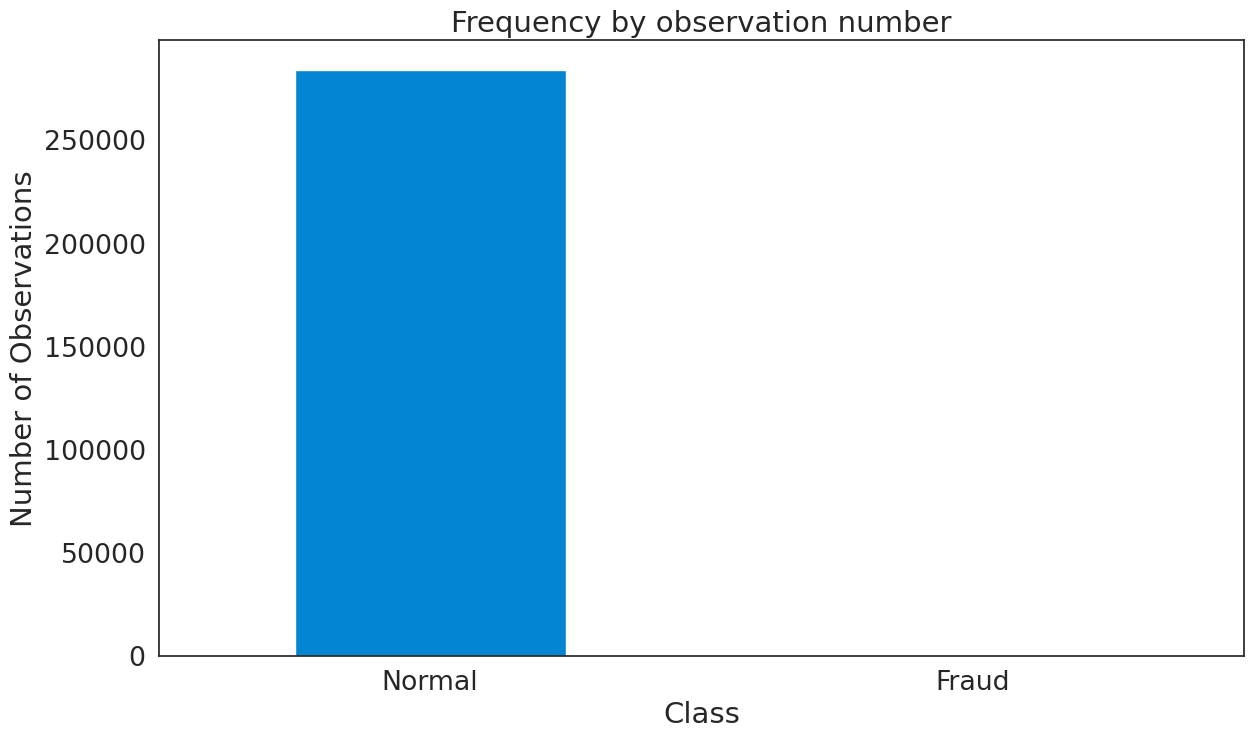

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, figsize=(14, 8))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

## Summary Statistics of the Transaction Amount Data
We will cut up the dataset into two data frames, one for normal transactions and the other for fraud.

In [ ]:
normal_df = df[df['Class']==0]
fraud_df = df[df['Class']==1]

In [ ]:
normal_df.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


In [ ]:
fraud_df.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.

## Visual Exploration of the Transaction Amount Data

In anomaly detection datasets it is common to have the areas of interest "washed out" by abundant data. In this dataset,  a lot of low-value transactions that will be generally uninteresting (buying cups of coffee, lunches, etc). This abundant data is likely to wash out the rest of the data, so looking at transactions which are $200+

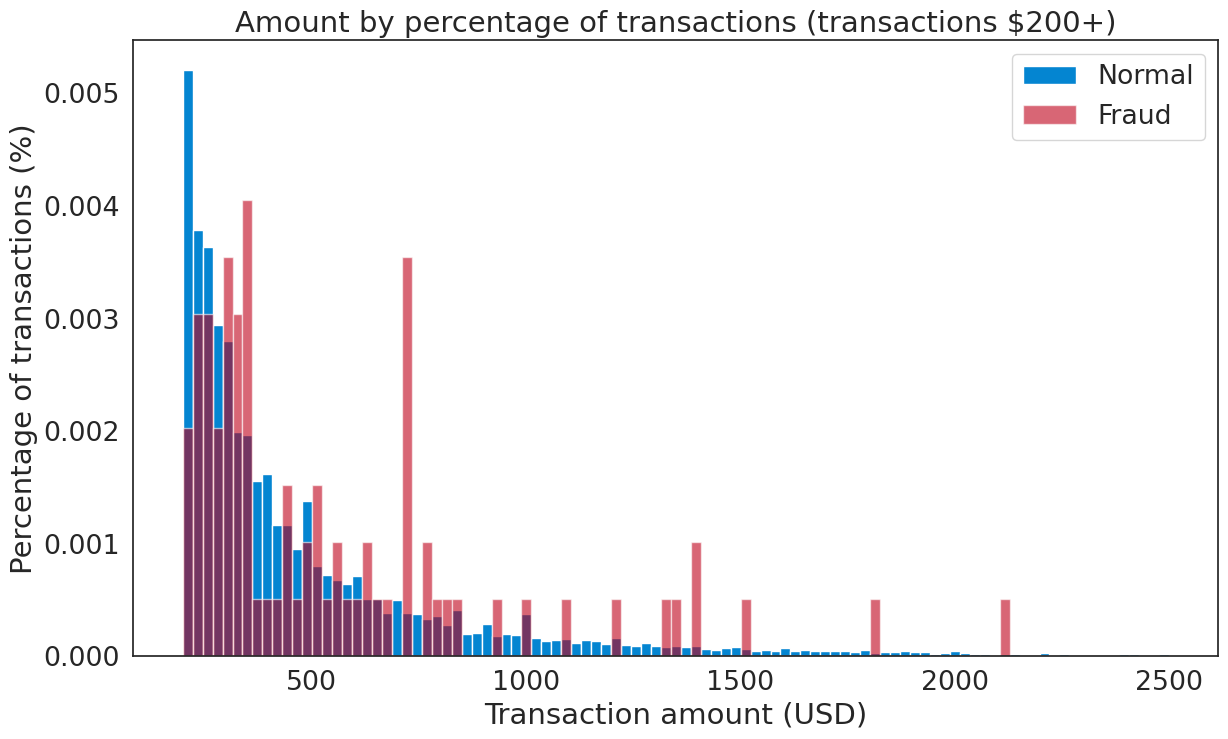

In [ ]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.figure(figsize=(14, 8))
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

Since the fraud cases are relatively few in number compared to bin size, we see the data looks predictably more variable. In the long tail, especially, we are likely observing only a single fraud transaction. It would be hard to differentiate fraud from normal transactions by transaction amount alone.

## Visual Exploration of the Data by Hour

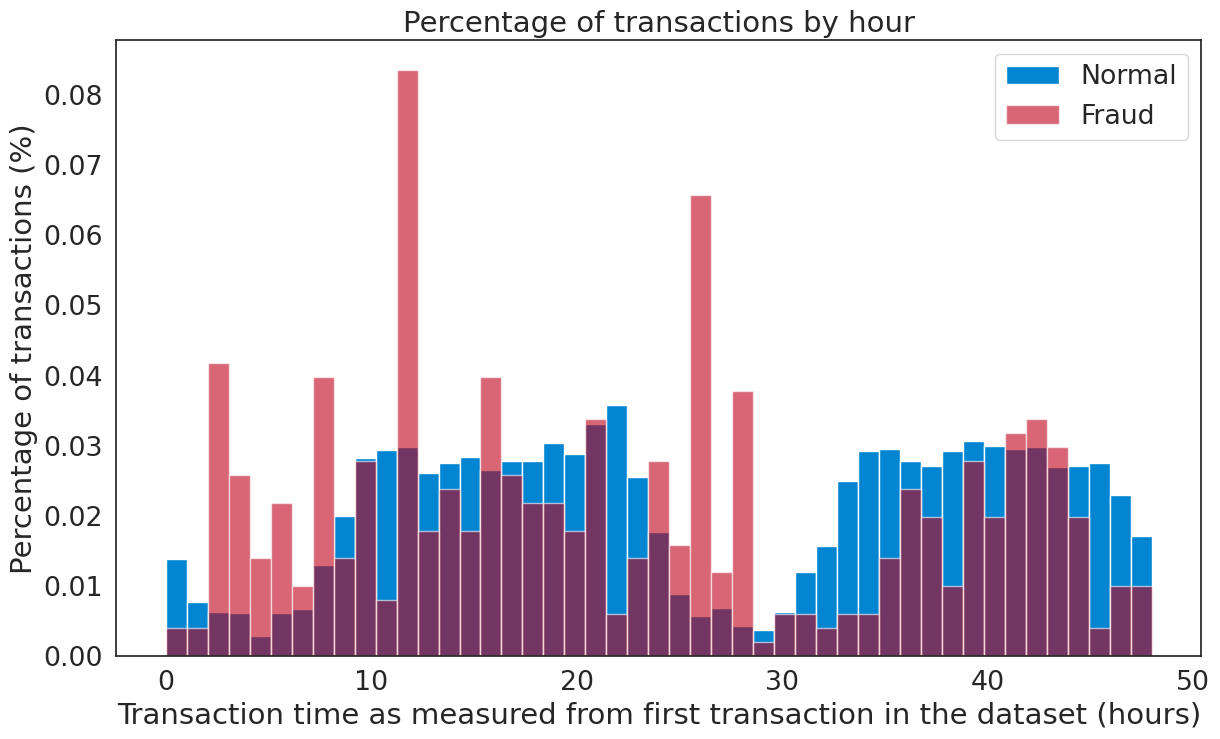

In [ ]:
bins = np.linspace(0, 48, 48) #48 hours
plt.figure(figsize=(14, 8))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
# plt.hist((df.Time/(60*60)),bins)
plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, I am assuming those time correspond to nighttime for this dataset. If this is true, fraud tends to occur at higher rates during the night. Statistical tests could be used to give evidence for this fact, but are not in the scope of this article. Again, however, the potential time offset between normal and fraud transactions is not enough to make a simple, precise classifier.

## Visual Exploration of Transaction Amount vs. Hour

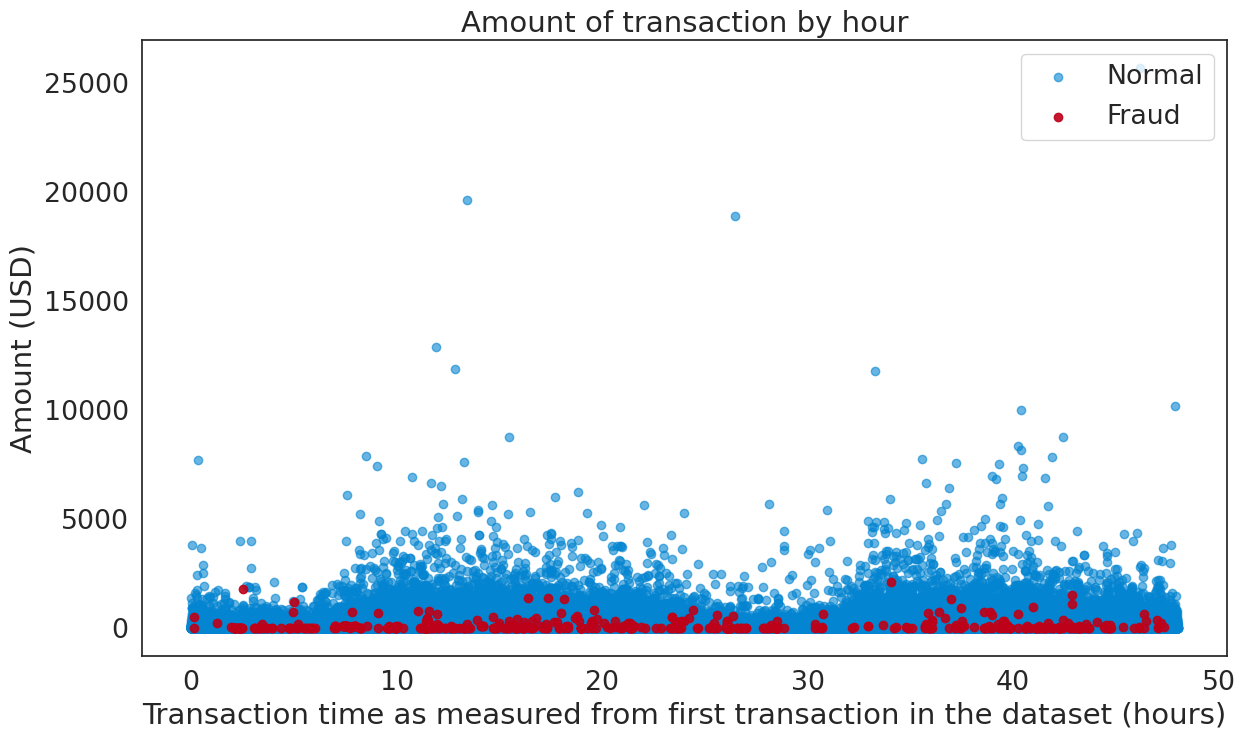

In [ ]:
plt.figure(figsize=(14, 8))
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

Again, this is not enough to make a good classifier. For example, it would be hard to draw a line that cleanly separates fraud and normal transactions.

# Basic Autoencoder


## Data Preprocessing

Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value. It is therefore common to scale the data to similar magnitudes. As most of the data (other than 'time' and 'amount') result from the product of a PCA analysis. The PCA done on the dataset transformed it into standard-normal form. I will do the same to the 'time' and 'amount' columns.

In [ ]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [ ]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

## Model Architecture
Autoencoder has symmetric encoding and decoding layers that are "dense".
We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, I am encoding 30 columns into 14 dimensions so I am expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [ ]:
nb_epoch = 50
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

In [ ]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument,
# kernel is a weights matrix created by the layer, and
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

## Training & Logging
Below is where we set up the actual run including checkpoints and the tensorboard.

In [ ]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard,
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/50
1774/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3975 - loss: 0.8392

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3977 - loss: 0.8389 - val_accuracy: 0.5647 - val_loss: 0.7025
Epoch 2/50
1759/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5790 - loss: 0.6525

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5792 - loss: 0.6523 - val_accuracy: 0.6078 - val_loss: 0.6432
Epoch 3/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6233 - loss: 0.5996

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6233 - loss: 0.5996 - val_accuracy: 0.6421 - val_loss: 0.6200
Epoch 4/50
1766/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - loss: 0.5832

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6432 - loss: 0.5831 - val_accuracy: 0.6475 - val_loss: 0.6055
Epoch 5/50
1774/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6484 - loss: 0.5686

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6484 - loss: 0.5686 - val_accuracy: 0.6456 - val_loss: 0.5958
Epoch 6/50
1775/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6512 - loss: 0.5477

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6512 - loss: 0.5478 - val_accuracy: 0.6503 - val_loss: 0.5879
Epoch 7/50
1758/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6542 - loss: 0.5357

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6542 - loss: 0.5359 - val_accuracy: 0.6436 - val_loss: 0.5840
Epoch 8/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 0.5480

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6579 - loss: 0.5480 - val_accuracy: 0.6610 - val_loss: 0.5776
Epoch 9/50
1777/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6623 - loss: 0.5439

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6623 - loss: 0.5439 - val_accuracy: 0.6549 - val_loss: 0.5761
Epoch 10/50
1765/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6640 - loss: 0.5533

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6640 - loss: 0.5532 - val_accuracy: 0.6651 - val_loss: 0.5719
Epoch 11/50
1767/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6679 - loss: 0.5412

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6679 - loss: 0.5412 - val_accuracy: 0.6680 - val_loss: 0.5699
Epoch 12/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6692 - loss: 0.5207 - val_accuracy: 0.6639 - val_loss: 0.5701
Epoch 13/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6683 - loss: 0.5443

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6683 - loss: 0.5442 - val_accuracy: 0.6668 - val_loss: 0.5680
Epoch 14/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6699 - loss: 0.5331

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6699 - loss: 0.5331 - val_accuracy: 0.6685 - val_loss: 0.5657
Epoch 15/50
1773/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 0.5463

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6724 - loss: 0.5462 - val_accuracy: 0.6753 - val_loss: 0.5634
Epoch 16/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6728 - loss: 0.5327

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6728 - loss: 0.5327 - val_accuracy: 0.6711 - val_loss: 0.5632
Epoch 17/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6730 - loss: 0.5267

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6730 - loss: 0.5267 - val_accuracy: 0.6710 - val_loss: 0.5631
Epoch 18/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6722 - loss: 0.5281

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6722 - loss: 0.5281 - val_accuracy: 0.6751 - val_loss: 0.5603
Epoch 19/50
1762/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6736 - loss: 0.5272

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6736 - loss: 0.5272 - val_accuracy: 0.6730 - val_loss: 0.5598
Epoch 20/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6754 - loss: 0.5305 - val_accuracy: 0.6715 - val_loss: 0.5604
Epoch 21/50
1777/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6755 - loss: 0.5136

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6755 - loss: 0.5136 - val_accuracy: 0.6795 - val_loss: 0.5585
Epoch 22/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6766 - loss: 0.5320

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6766 - loss: 0.5319 - val_accuracy: 0.6809 - val_loss: 0.5577
Epoch 23/50
1760/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6777 - loss: 0.5246

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6777 - loss: 0.5246 - val_accuracy: 0.6813 - val_loss: 0.5566
Epoch 24/50
1765/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6773 - loss: 0.5210

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6773 - loss: 0.5210 - val_accuracy: 0.6792 - val_loss: 0.5556
Epoch 25/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6798 - loss: 0.5320 - val_accuracy: 0.6786 - val_loss: 0.5568
Epoch 26/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6797 - loss: 0.5315 - val_accuracy: 0.6813 - val_loss: 0.5565
Epoch 27/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.5461

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6792 - loss: 0.5461 - val_accuracy: 0.6848 - val_loss: 0.5536
Epoch 28/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6804 - loss: 0.5229 - val_accuracy: 0.6821 - val_loss: 0.5554
Epoch 29/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6807 - loss: 0.5146 - val_accuracy: 0.6829 - val_loss: 0.5550
Epoch 30/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6820 - loss: 0.5136 - val_accuracy: 0.6801 - val_loss: 0.5548
Epoch 31/50
1775/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6817 - loss: 0.5132

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6817 - loss: 0.5133 - val_accuracy: 0.6834 - val_loss: 0.5521
Epoch 32/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6833 - loss: 0.5160 - val_accuracy: 0.6873 - val_loss: 0.5526
Epoch 33/50
1767/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6802 - loss: 0.5259

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6802 - loss: 0.5259 - val_accuracy: 0.6849 - val_loss: 0.5504
Epoch 34/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6828 - loss: 0.5108 - val_accuracy: 0.6874 - val_loss: 0.5523
Epoch 35/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6829 - loss: 0.5313 - val_accuracy: 0.6858 - val_loss: 0.5514
Epoch 36/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6821 - loss: 0.5233 - val_accuracy: 0.6821 - val_loss: 0.5509
Epoch 37/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 0.5316

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6846 - loss: 0.5315 - val_accuracy: 0.6926 - val_loss: 0.5496
Epoch 38/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6863 - loss: 0.5136

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6863 - loss: 0.5136 - val_accuracy: 0.6887 - val_loss: 0.5495
Epoch 39/50
1767/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6854 - loss: 0.5271

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6854 - loss: 0.5271 - val_accuracy: 0.6897 - val_loss: 0.5487
Epoch 40/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6862 - loss: 0.5145 - val_accuracy: 0.6827 - val_loss: 0.5528
Epoch 41/50
1773/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6879 - loss: 0.5196

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6879 - loss: 0.5196 - val_accuracy: 0.6919 - val_loss: 0.5474
Epoch 42/50
1777/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6913 - loss: 0.5202

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6913 - loss: 0.5201 - val_accuracy: 0.6935 - val_loss: 0.5469
Epoch 43/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6898 - loss: 0.5163 - val_accuracy: 0.6937 - val_loss: 0.5471
Epoch 44/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6891 - loss: 0.5261 - val_accuracy: 0.6917 - val_loss: 0.5482
Epoch 45/50
1765/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6899 - loss: 0.5357

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6899 - loss: 0.5355 - val_accuracy: 0.6917 - val_loss: 0.5457
Epoch 46/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6914 - loss: 0.5146 - val_accuracy: 0.6926 - val_loss: 0.5464
Epoch 47/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6925 - loss: 0.5046 - val_accuracy: 0.6872 - val_loss: 0.5486
Epoch 48/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6903 - loss: 0.5112 - val_accuracy: 0.6936 - val_loss: 0.5464
Epoch 49/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6916 - loss: 0.5150 - val_accuracy: 0.6915 - val_loss: 0.5460
Epoch 50/50
1758/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6918 - loss: 0.5004

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6918 - loss: 0.5005 - val_accuracy: 0.6959 - val_loss: 0.5448


In [ ]:
# Visualizing metrics on local system
# !tensorboard --logdir='logs'

# Denoising AE + SMOTE

## Data Preprocessing

In [ ]:
from imblearn.over_sampling import SMOTE

# Keep the original train_x with both normal and fraud transactions
train_x2, test_x2 = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_y2 = train_x2['Class']  # Extract the target variable (Class)
train_x2 = train_x2.drop(['Class'], axis=1)  # Drop the 'Class' column from train_x
test_y2 = test_x2['Class']  # Extract the target variable (Class) for the test set
test_x2 = test_x2.drop(['Class'], axis=1)  # Drop the 'Class' column from test_x

# Apply SMOTE oversampling
smote = SMOTE(random_state=RANDOM_SEED)
train_x_res2, train_y_res2 = smote.fit_resample(train_x2, train_y2)

# Convert to numpy arrays
train_x_res2 = train_x_res2.values
train_y_res2 = train_y_res2.values
test_x2 = test_x2.values
test_y2 = test_y2.values

# Now implement the Denoising Autoencoder
from keras.layers import GaussianNoise, Dropout


## Model Architecture

In [ ]:
# Parameters
input_dim = train_x_res2.shape[1]  # Number of features
encoding_dim = 18
hidden_dim1 = 10
hidden_dim2 = 6
learning_rate = 1e-7
noise_factor = 0.1  # Amount of noise to add for denoising

In [ ]:
input_layer1 = Input(shape=(input_dim,), name="clean_input1")
noisy_input1 = GaussianNoise(noise_factor, name="gauss_noise1")(input_layer1)
encoder_dense1_1 = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(1e-7), name="encode_dense1_1")(noisy_input1)
encoder_dense2_1 = Dense(hidden_dim1, activation="elu", name="encode_dense2_1")(encoder_dense1_1)
bottleneck1 = Dense(hidden_dim2, activation="tanh", name="bottleneck1")(encoder_dense2_1)
decoder_dense1_1 = Dense(hidden_dim2, activation="elu", name="decode_dense1_1")(bottleneck1)
decoder_dense2_1 = Dense(hidden_dim1, activation="tanh", name="decode_dense2_1")(decoder_dense1_1)
reconstruction1 = Dense(input_dim, activation="elu", name="reconstruction1")(decoder_dense2_1)

dae1 = Model(inputs=input_layer1, outputs=reconstruction1, name="DenoisingAutoencoder1")
# dae1.compile(optimizer="adam", loss="mse")
# dae1.summary()


In [ ]:
dae1.compile(optimizer="adam", loss="mse")
dae1.fit(
    train_x_res2, train_x_res2,
    epochs=50,
    batch_size=256,
    validation_data=(test_x2, test_x2)
)

Epoch 1/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 11.4873 - val_loss: 0.8635
Epoch 2/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 10.2929 - val_loss: 0.8036
Epoch 3/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.8859 - val_loss: 0.7710
Epoch 4/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 9.7912 - val_loss: 0.7489
Epoch 5/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.7667 - val_loss: 0.7186
Epoch 6/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.7506 - val_loss: 0.7009
Epoch 7/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 9.7352 - val_loss: 0.6907
Epoch 8/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.6845 - val_loss: 0.6847
Epoch 9/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 9.6989 - val_loss: 0.6822
Epoch 10/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.6580 - val_loss: 0.6772
Epoch 11/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.6532 - val_loss: 0.6735
Epoch 12/50
1778/1778 ━━

Use the trained DAE to denoise the data

In [ ]:
train_x_den = dae1.predict(train_x_res2)
test_x_den  = dae1.predict(test_x2)

14217/14217 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


## Classification

In [ ]:
num_classes = 2                       # normal vs. fraud
input_dim   = train_x_den.shape[1]    # number of features after denoising
clf_input = Input(shape=(input_dim,), name="clf_input")
x = Dense(22, activation="relu")(clf_input)
x = Dense(15, activation="relu")(x)
x = Dense(10, activation="relu")(x)
x = Dense(5,  activation="relu")(x)
x = Dense(2,  activation="relu")(x)
out = Dense(num_classes, activation="softmax", name="clf_output")(x)

classifier = Model(inputs=clf_input, outputs=out, name="classifier")
classifier.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
from keras.utils import to_categorical


In [ ]:
train_y_cat = to_categorical(train_y_res2, num_classes)
test_y_cat  = to_categorical(test_y2,    num_classes)

In [ ]:
classifier.fit(
    train_x_den, train_y_cat,
    epochs=30,
    batch_size=128,
    validation_data=(test_x_den, test_y_cat)
)

Epoch 1/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9139 - loss: 0.2641 - val_accuracy: 0.9708 - val_loss: 0.0728
Epoch 2/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9802 - loss: 0.0583 - val_accuracy: 0.9876 - val_loss: 0.0363
Epoch 3/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9835 - loss: 0.0457 - val_accuracy: 0.9834 - val_loss: 0.0476
Epoch 4/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9858 - loss: 0.0401 - val_accuracy: 0.9816 - val_loss: 0.0529
Epoch 5/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9865 - loss: 0.0381 - val_accuracy: 0.9858 - val_loss: 0.0397
Epoch 6/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9874 - loss: 0.0353 - val_accuracy: 0.9833 - val_loss: 0.0484
Epoch 7/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9876 - loss: 0.0348 - val_accuracy: 0.9829 - val_loss: 0.0490
Epoch 8/30
3555/3555 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9886 - loss: 0.03

# Variational Autoencoder

## Data Preprocessing

In [ ]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [ ]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

## Model Architecture

In [ ]:
noise_stddev  = 0.1
latent_dim  = 18
l2_lambda   = 1e-7

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = Input(shape=(input_dim,), name="encoder_input")
x = Dense(hidden_dim1,
          activation="elu",
          kernel_regularizer=regularizers.l2(l2_lambda),
          name="enc_dense1")(encoder_inputs)
x = Dense(hidden_dim2, activation="tanh", name="enc_dense2")(x)
z_mean    = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z         = Lambda(sampling, name="z")([z_mean, z_log_var])
encoder   = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
x = Dense(hidden_dim2, activation="elu", name="dec_dense1")(latent_inputs)
x = Dense(hidden_dim1, activation="tanh", name="dec_dense2")(x)
decoder_outputs = Dense(input_dim, activation="linear", name="decoder_output")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker          = metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker             = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            rec_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=-1)
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var
                              - tf.square(z_mean)
                              - tf.exp(z_log_var),
                              axis=-1)
            )
            total_loss = rec_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(rec_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss":               self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss":             self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        rec_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(x - reconstruction), axis=-1)
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var
                          - tf.square(z_mean)
                          - tf.exp(z_log_var),
                          axis=-1)
        )
        total_loss = rec_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(rec_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss":               total_loss,
            "reconstruction_loss": rec_loss,
            "kl_loss":             kl_loss,
        }


## Training & Logging

In [ ]:
# Instantiate and compile
vae = VAE(encoder, decoder, name="VAE")
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Callbacks
checkpoint = ModelCheckpoint("vae_best.h5", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir="logs/vae", histogram_freq=1)

# Training
history2 = vae.fit(
    train_x,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_x, None),
    callbacks=[checkpoint, tensorboard]
).history

Epoch 1/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7458 - loss: 19.9241 - reconstruction_loss: 16.1783
Epoch 1: val_loss improved from inf to 20.78185, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 3.7458 - loss: 19.9242 - reconstruction_loss: 16.1784 - val_kl_loss: 3.7875 - val_loss: 20.7818 - val_reconstruction_loss: 16.9943
Epoch 2/50
1776/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7605 - loss: 19.6994 - reconstruction_loss: 15.9389
Epoch 2: val_loss improved from 20.78185 to 20.76731, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 3.7605 - loss: 19.6998 - reconstruction_loss: 15.9393 - val_kl_loss: 3.7728 - val_loss: 20.7673 - val_reconstruction_loss: 16.9945
Epoch 3/50
1775/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.7649 - loss: 19.9727 - reconstruction_loss: 16.2078
Epoch 3: val_loss improved from 20.76731 to 20.76567, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - kl_loss: 3.7649 - loss: 19.9725 - reconstruction_loss: 16.2077 - val_kl_loss: 3.7880 - val_loss: 20.7657 - val_reconstruction_loss: 16.9777
Epoch 4/50
1766/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7681 - loss: 19.9209 - reconstruction_loss: 16.1528
Epoch 4: val_loss improved from 20.76567 to 20.71958, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 3.7681 - loss: 19.9208 - reconstruction_loss: 16.1526 - val_kl_loss: 3.8076 - val_loss: 20.7196 - val_reconstruction_loss: 16.9120
Epoch 5/50
1763/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7776 - loss: 19.9591 - reconstruction_loss: 16.1815
Epoch 5: val_loss did not improve from 20.71958
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kl_loss: 3.7775 - loss: 19.9588 - reconstruction_loss: 16.1813 - val_kl_loss: 3.8442 - val_loss: 20.7983 - val_reconstruction_loss: 16.9541
Epoch 6/50
1765/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.7769 - loss: 19.6643 - reconstruction_loss: 15.8874
Epoch 6: val_loss did not improve from 20.71958
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kl_loss: 3.7770 - loss: 19.6660 - reconstruction_loss: 15.8890 - val_kl_loss: 3.7591 - val_loss: 20.7411 - val_reconstruction_loss: 16.9821
Epoch 7/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7675 - loss: 19.5425 - reconstruction_loss

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - kl_loss: 3.7642 - loss: 20.4839 - reconstruction_loss: 16.7196 - val_kl_loss: 3.7945 - val_loss: 20.7130 - val_reconstruction_loss: 16.9185
Epoch 10/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7900 - loss: 19.9252 - reconstruction_loss: 16.1352
Epoch 10: val_loss improved from 20.71298 to 20.70614, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 3.7899 - loss: 19.9252 - reconstruction_loss: 16.1353 - val_kl_loss: 3.7746 - val_loss: 20.7061 - val_reconstruction_loss: 16.9316
Epoch 11/50
1769/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.7924 - loss: 19.6204 - reconstruction_loss: 15.8280
Epoch 11: val_loss did not improve from 20.70614
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - kl_loss: 3.7924 - loss: 19.6216 - reconstruction_loss: 15.8293 - val_kl_loss: 3.7962 - val_loss: 20.7316 - val_reconstruction_loss: 16.9353
Epoch 12/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7904 - loss: 19.6872 - reconstruction_loss: 15.8969
Epoch 12: val_loss improved from 20.70614 to 20.67130, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - kl_loss: 3.7904 - loss: 19.6873 - reconstruction_loss: 15.8969 - val_kl_loss: 3.7673 - val_loss: 20.6713 - val_reconstruction_loss: 16.9040
Epoch 13/50
1767/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 3.7933 - loss: 19.7904 - reconstruction_loss: 15.9970
Epoch 13: val_loss improved from 20.67130 to 20.66510, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - kl_loss: 3.7933 - loss: 19.7907 - reconstruction_loss: 15.9973 - val_kl_loss: 3.8533 - val_loss: 20.6651 - val_reconstruction_loss: 16.8118
Epoch 14/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8008 - loss: 19.8738 - reconstruction_loss: 16.0731
Epoch 14: val_loss improved from 20.66510 to 20.64703, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 3.8007 - loss: 19.8737 - reconstruction_loss: 16.0730 - val_kl_loss: 3.8208 - val_loss: 20.6470 - val_reconstruction_loss: 16.8262
Epoch 15/50
1772/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8017 - loss: 19.7390 - reconstruction_loss: 15.9373
Epoch 15: val_loss improved from 20.64703 to 20.62841, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - kl_loss: 3.8017 - loss: 19.7393 - reconstruction_loss: 15.9377 - val_kl_loss: 3.8286 - val_loss: 20.6284 - val_reconstruction_loss: 16.7999
Epoch 16/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.8035 - loss: 19.7495 - reconstruction_loss: 15.9460
Epoch 16: val_loss did not improve from 20.62841
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - kl_loss: 3.8035 - loss: 19.7498 - reconstruction_loss: 15.9463 - val_kl_loss: 3.8064 - val_loss: 20.6494 - val_reconstruction_loss: 16.8429
Epoch 17/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7949 - loss: 19.9053 - reconstruction_loss: 16.1103
Epoch 17: val_loss did not improve from 20.62841
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - kl_loss: 3.7950 - loss: 19.9045 - reconstruction_loss: 16.1095 - val_kl_loss: 3.8135 - val_loss: 20.6442 - val_reconstruction_loss: 16.8307
Epoch 18/50
1760/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7961 - loss: 19.6958 - reconstruction_

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - kl_loss: 3.8027 - loss: 19.6392 - reconstruction_loss: 15.8366 - val_kl_loss: 3.8199 - val_loss: 20.6120 - val_reconstruction_loss: 16.7921
Epoch 24/50
1774/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.8088 - loss: 19.4939 - reconstruction_loss: 15.6850
Epoch 24: val_loss did not improve from 20.61201
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - kl_loss: 3.8088 - loss: 19.4946 - reconstruction_loss: 15.6857 - val_kl_loss: 3.8065 - val_loss: 20.7991 - val_reconstruction_loss: 16.9926
Epoch 25/50
1773/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.8045 - loss: 19.7514 - reconstruction_loss: 15.9469
Epoch 25: val_loss improved from 20.61201 to 20.56830, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - kl_loss: 3.8045 - loss: 19.7514 - reconstruction_loss: 15.9469 - val_kl_loss: 3.8263 - val_loss: 20.5683 - val_reconstruction_loss: 16.7420
Epoch 26/50
1771/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.7958 - loss: 19.5367 - reconstruction_loss: 15.7409
Epoch 26: val_loss did not improve from 20.56830
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - kl_loss: 3.7958 - loss: 19.5377 - reconstruction_loss: 15.7418 - val_kl_loss: 3.7716 - val_loss: 20.7184 - val_reconstruction_loss: 16.9468
Epoch 27/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.8055 - loss: 19.5417 - reconstruction_loss: 15.7361
Epoch 27: val_loss did not improve from 20.56830
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - kl_loss: 3.8055 - loss: 19.5433 - reconstruction_loss: 15.7378 - val_kl_loss: 3.7999 - val_loss: 20.7286 - val_reconstruction_loss: 16.9288
Epoch 28/50
1767/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8081 - loss: 19.6740 - reconstruction_

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - kl_loss: 3.8206 - loss: 19.5797 - reconstruction_loss: 15.7591 - val_kl_loss: 3.8295 - val_loss: 20.5628 - val_reconstruction_loss: 16.7333
Epoch 34/50
1776/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8240 - loss: 19.6091 - reconstruction_loss: 15.7851
Epoch 34: val_loss did not improve from 20.56281
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - kl_loss: 3.8240 - loss: 19.6092 - reconstruction_loss: 15.7852 - val_kl_loss: 3.7721 - val_loss: 20.6004 - val_reconstruction_loss: 16.8283
Epoch 35/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8112 - loss: 19.6468 - reconstruction_loss: 15.8355
Epoch 35: val_loss did not improve from 20.56281
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - kl_loss: 3.8112 - loss: 19.6471 - reconstruction_loss: 15.8359 - val_kl_loss: 3.8185 - val_loss: 20.5677 - val_reconstruction_loss: 16.7492
Epoch 36/50
1762/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8231 - loss: 19.5214 - reconstruction_l

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - kl_loss: 3.8295 - loss: 19.8170 - reconstruction_loss: 15.9875 - val_kl_loss: 3.7979 - val_loss: 20.5361 - val_reconstruction_loss: 16.7382
Epoch 40/50
1771/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8198 - loss: 19.5394 - reconstruction_loss: 15.7196
Epoch 40: val_loss did not improve from 20.53613
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 3.8198 - loss: 19.5401 - reconstruction_loss: 15.7202 - val_kl_loss: 3.8120 - val_loss: 20.6083 - val_reconstruction_loss: 16.7963
Epoch 41/50
1764/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8207 - loss: 19.7214 - reconstruction_loss: 15.9007
Epoch 41: val_loss did not improve from 20.53613
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 3.8207 - loss: 19.7217 - reconstruction_loss: 15.9010 - val_kl_loss: 3.7949 - val_loss: 20.5503 - val_reconstruction_loss: 16.7554
Epoch 42/50
1760/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8199 - loss: 19.6945 - reconstruction_

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - kl_loss: 3.8277 - loss: 19.4483 - reconstruction_loss: 15.6206 - val_kl_loss: 3.8385 - val_loss: 20.5078 - val_reconstruction_loss: 16.6692
Epoch 45/50
1770/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.8397 - loss: 19.6484 - reconstruction_loss: 15.8087
Epoch 45: val_loss did not improve from 20.50776
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kl_loss: 3.8396 - loss: 19.6485 - reconstruction_loss: 15.8089 - val_kl_loss: 3.8283 - val_loss: 20.5623 - val_reconstruction_loss: 16.7340
Epoch 46/50
1766/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8208 - loss: 19.5106 - reconstruction_loss: 15.6897
Epoch 46: val_loss improved from 20.50776 to 20.49804, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - kl_loss: 3.8209 - loss: 19.5116 - reconstruction_loss: 15.6907 - val_kl_loss: 3.8299 - val_loss: 20.4980 - val_reconstruction_loss: 16.6681
Epoch 47/50
1766/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8238 - loss: 20.0676 - reconstruction_loss: 16.2438
Epoch 47: val_loss improved from 20.49804 to 20.49743, saving model to vae_best.h5


1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - kl_loss: 3.8239 - loss: 20.0650 - reconstruction_loss: 16.2411 - val_kl_loss: 3.8425 - val_loss: 20.4974 - val_reconstruction_loss: 16.6549
Epoch 48/50
1765/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.8209 - loss: 19.5326 - reconstruction_loss: 15.7117
Epoch 48: val_loss did not improve from 20.49743
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 3.8209 - loss: 19.5333 - reconstruction_loss: 15.7124 - val_kl_loss: 3.8675 - val_loss: 20.5979 - val_reconstruction_loss: 16.7305
Epoch 49/50
1768/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8249 - loss: 19.7291 - reconstruction_loss: 15.9042
Epoch 49: val_loss did not improve from 20.49743
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - kl_loss: 3.8249 - loss: 19.7288 - reconstruction_loss: 15.9038 - val_kl_loss: 3.7941 - val_loss: 20.5125 - val_reconstruction_loss: 16.7184
Epoch 50/50
1766/1778 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.8173 - loss: 19.4336 - reconstruction_l

# Model Evaluation

## Model Loss


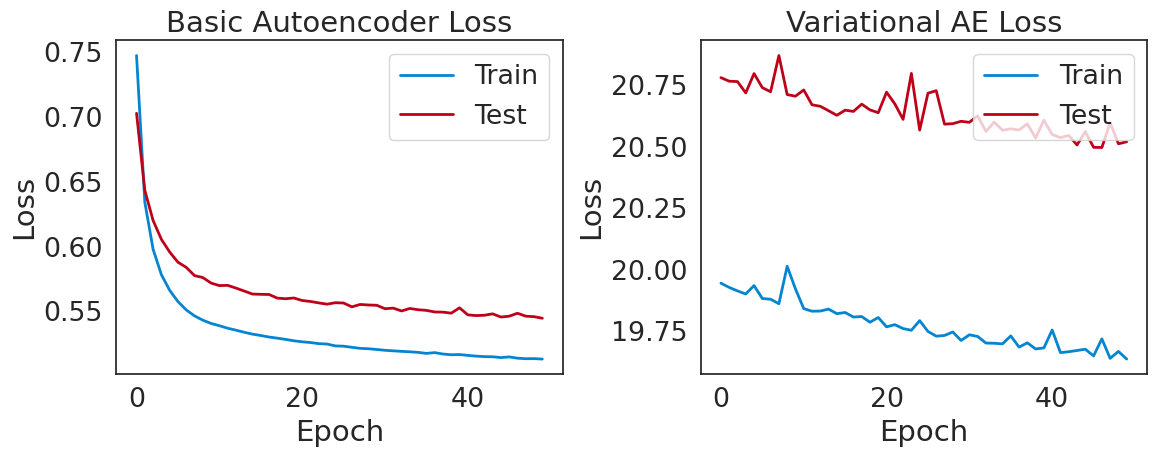

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (hist, title) in zip(axes, [
    (history, 'Basic Autoencoder'),
    (history2, 'Variational AE')
]):
    ax.plot(hist['loss'], linewidth=2, label='Train')
    ax.plot(hist['val_loss'], linewidth=2, label='Test')
    ax.legend(loc='upper right')
    ax.set_title(f'{title} Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

plt.tight_layout()
plt.show()


## Reconstruction Error Check
Autoencoders are trained to reduce reconstruction error which we show below:

In [ ]:
# Predict reconstructions with Basic AE and VAE2
ae_pred  = autoencoder.predict(test_x)    # Basic Autoencoder predictions
vae_pred = vae.predict(test_x)      # Variational AE2 predictions

# Compute mean squared error per sample for each model
mse_ae  = np.mean((test_x - ae_pred)  ** 2, axis=1)
mse_vae = np.mean((test_x - vae_pred) ** 2, axis=1)

# Assemble a DataFrame containing reconstruction errors and true labels
error_df = pd.DataFrame({
    'AE_error':  mse_ae,
    'VAE_error': mse_vae,
    'True_class': test_y
})

# Display summary statistics for each model's reconstruction error
error_df.describe()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


,AE_error,VAE_error,True_class
count,56962.000000,56962.000000,56962.000000
mean,0.544684,0.556681,0.002019
std,3.011754,1.849814,0.044887
min,0.020894,0.047231,0.000000
25%,0.149719,0.234396,0.000000
50%,0.237519,0.349670,0.000000
75%,0.404909,0.570811,0.000000
max,191.032405,136.396412,1.000000


## ROC Curve Check


In [ ]:
model_errors = {
    'Basic Autoencoder':   'AE_error',
    'Variational AE2':      'VAE_error'
}

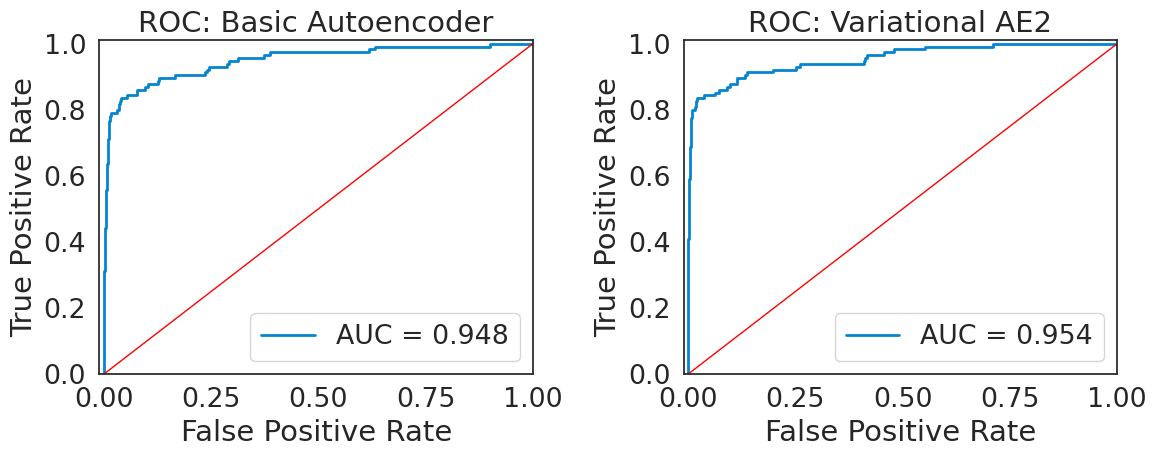

In [ ]:
# Compute and plot ROC for each model
roc_results = {}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loop through each model and its corresponding axis
for ax, (model_name, col) in zip(axes, model_errors.items()):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(
        error_df['True_class'],
        error_df[col]
    )
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    ax.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='red')
    ax.set_xlim([-0.01, 1])
    ax.set_ylim([0, 1.01])
    ax.set_title(f'ROC: {model_name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# y_true   = test_y2
# y_scores = classifier.predict(test_x_den)[:, 1]

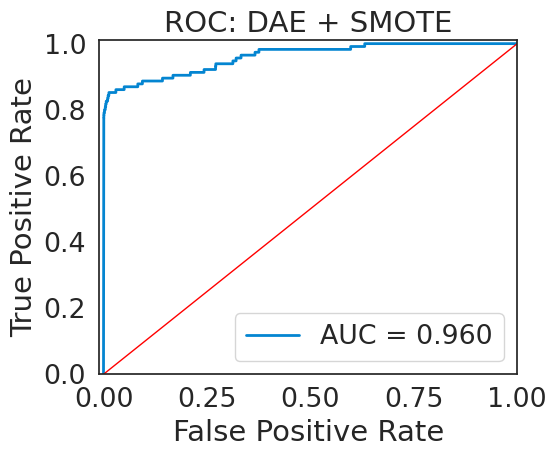

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
ax.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='red')
ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.set_title('ROC: DAE + SMOTE')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Recall vs. Precision Thresholding



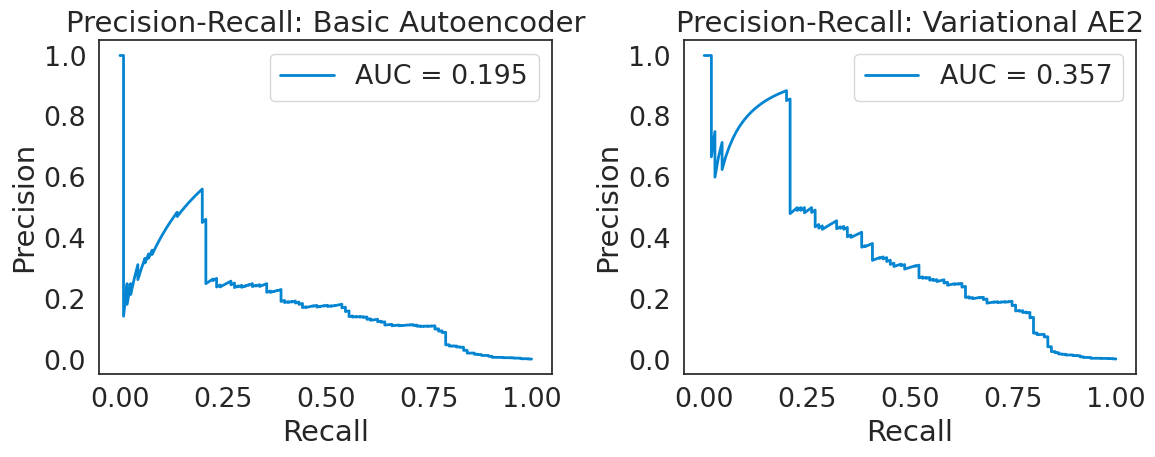

In [ ]:
# calculates precision/recall using reconstruction error as the decision function
# returns:
# precision_rt: Precision values such that element i is the precision of predictions with
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

pr_results = {}
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (model_name, col) in zip(axes, model_errors.items()):
    # compute precision, recall and thresholds
    precision, recall, thresholds = precision_recall_curve(
        error_df['True_class'],
        error_df[col]
    )
    # compute area under PR curve
    pr_auc = auc(recall, precision)
    # store for later
    pr_results[model_name] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds,
        'auc': pr_auc
    }

    # plot on the shared figure
    ax.plot(recall, precision, linewidth=2, label=f'AUC = {pr_auc:.3f}')
    ax.legend(loc='upper right')
    ax.set_title(f'Precision-Recall: {model_name}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

plt.tight_layout()
plt.show()

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.

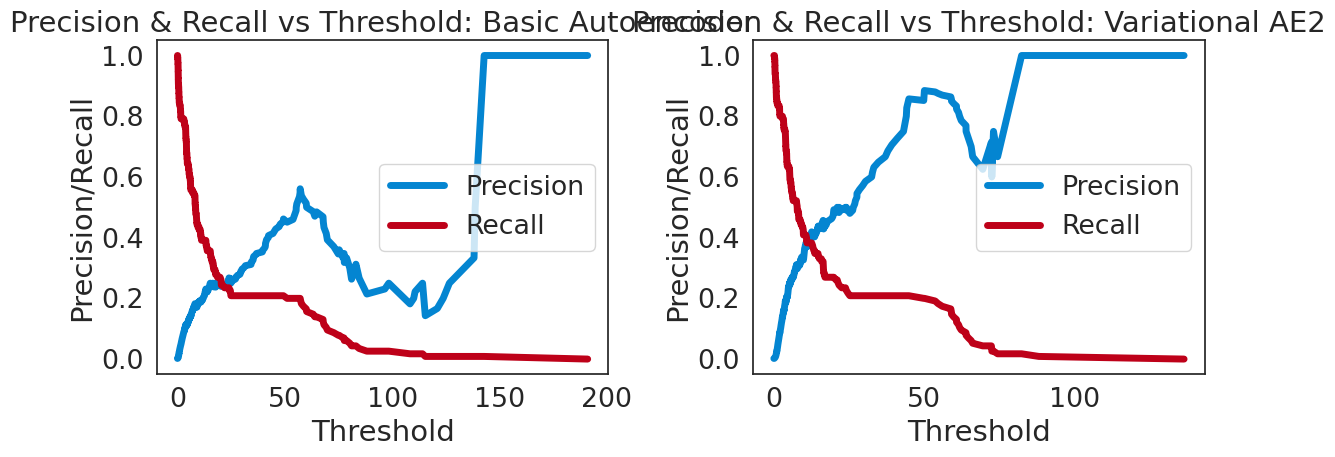

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (model_name, col) in zip(axes, model_errors.items()):
    precision, recall, thresholds = precision_recall_curve(
        error_df['True_class'], error_df[col]
    )
    ax.plot(thresholds, precision[1:], label='Precision', linewidth=5)
    ax.plot(thresholds, recall[1:],    label='Recall',    linewidth=5)
    ax.set_title(f'Precision & Recall vs Threshold: {model_name}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Precision/Recall')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


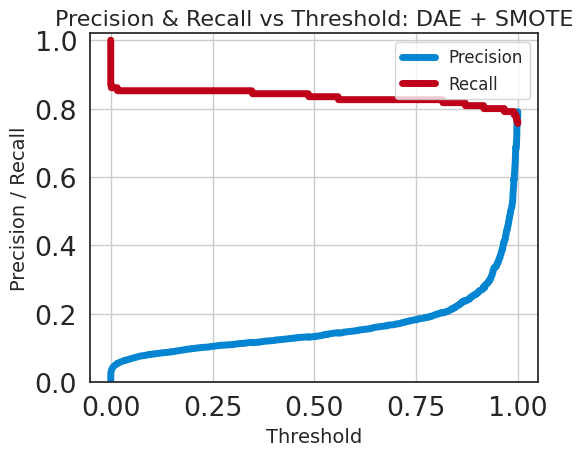

In [ ]:
from sklearn.metrics import precision_score, recall_score

y_true   = test_y2
y_scores = classifier.predict(test_x_den)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(thresholds, precision[:-1], label='Precision', linewidth=5)
ax.plot(thresholds, recall[:-1],    label='Recall',    linewidth=5)

ax.set_title('Precision & Recall vs Threshold: DAE + SMOTE', fontsize=16)
ax.set_xlabel('Threshold', fontsize=14)
ax.set_ylabel('Precision / Recall', fontsize=14)
ax.set_ylim(0, 1.02)
ax.legend(loc='best', fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()

## Reconstruction Error vs Threshold Check

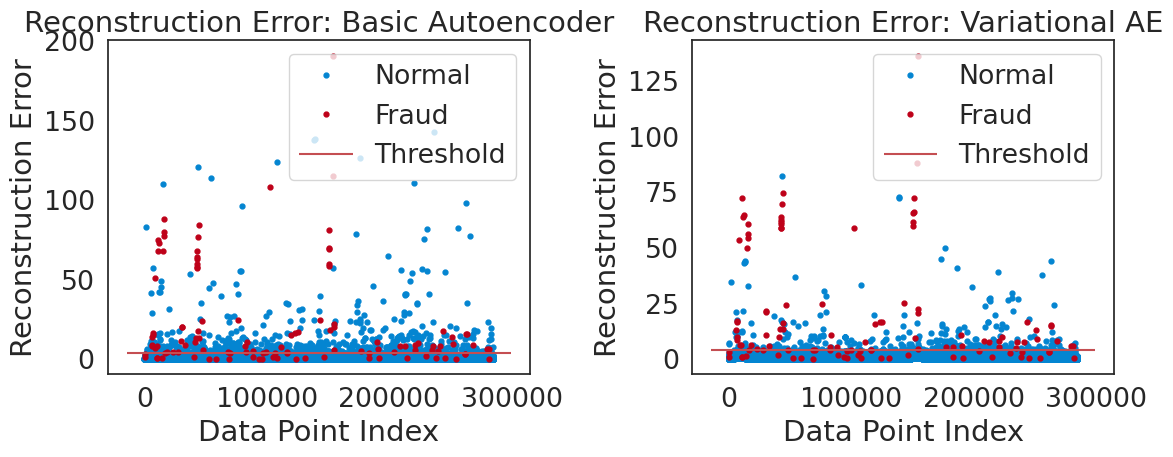

In [ ]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (model_name, col) in zip(axes, [
    ('Basic Autoencoder', 'AE_error'),
    ('Variational AE',     'VAE_error')
]):
    for name, group in groups:
        ax.plot(
            group.index, group[col],
            marker='o', ms=3.5, linestyle='',
            label='Fraud' if name == 1 else 'Normal'
        )
    ax.hlines(
        threshold_fixed,
        ax.get_xlim()[0], ax.get_xlim()[1],
        colors='r', zorder=100, label='Threshold'
    )
    ax.set_title(f'Reconstruction Error: {model_name}')
    ax.set_xlabel('Data Point Index')
    ax.set_ylabel('Reconstruction Error')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Confusion Matrix
Finally, we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. Here I really take a look at the ratio of detected fraud cases to false positives. A 1:10 ratio is a fairly standard benchmark if there are no business rules or cost tradeoffs that dominate that decision.

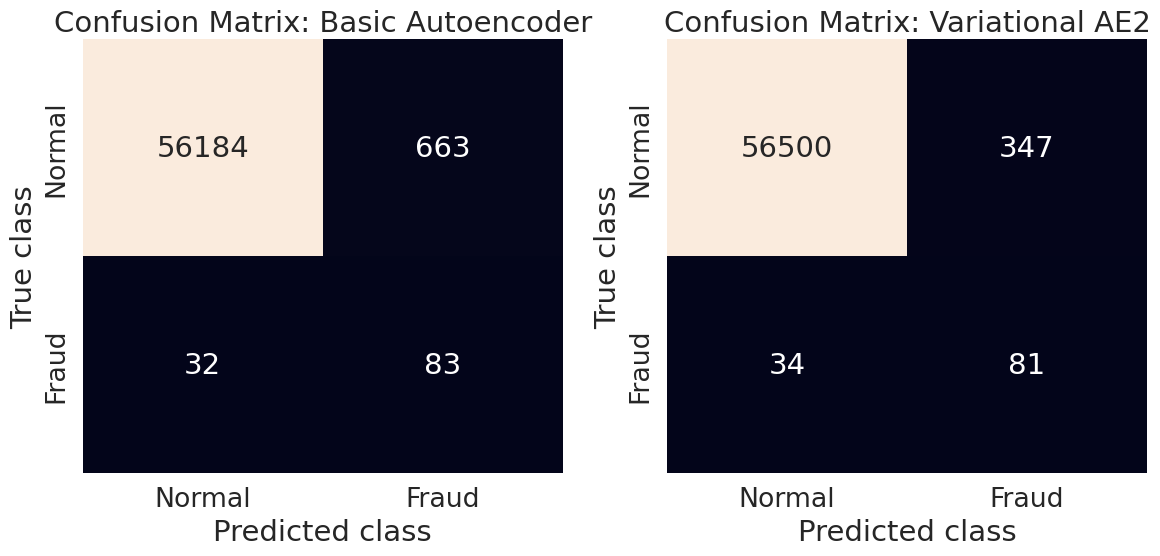

In [ ]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
LABELS = ['Normal', 'Fraud']

# 1×3 subplot for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (model_name, col) in zip(axes, model_errors.items()):
    # predict with fixed threshold
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df[col].values]
    # compute confusion matrix
    conf_matrix = confusion_matrix(error_df['True_class'], pred_y)
    # plot heatmap
    sns.heatmap(conf_matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True, fmt="d",
                ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')

plt.tight_layout()
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


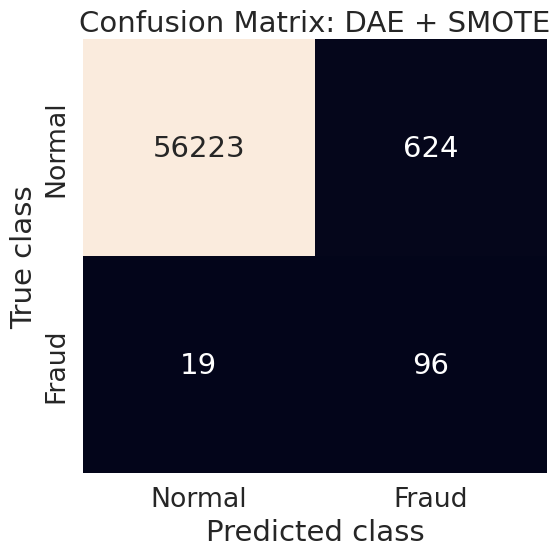

In [ ]:
threshold_fixed = 0.5
LABELS = ['Normal', 'Fraud']

y_true   = test_y2
y_scores = classifier.predict(test_x_den)[:, 1]
y_pred   = (y_scores > threshold_fixed).astype(int)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.heatmap(cm,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True, fmt="d",
            ax=ax, cbar=False)
ax.set_title('Confusion Matrix: DAE + SMOTE')
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')

plt.tight_layout()
plt.show()

Source: [datascience.com](http://www.datascience.com/blog/fraud-detection-with-tensorflow?utm_medium=email&_hsenc=p2ANqtz-9IZ7jpDKVn9-SJB_tVIKpBXp3QVcAC6cZivlugt6ptH8oHWCgodII9b0b_uC-Wyz3oVoXiPn4eBfDfEXqVPbPhHw1SaA&_hsmi=65196762&utm_content=65196762&utm_source=hs_email&hsCtaTracking=ed11a1c4-fe1e-4029-9f9c-fe0f8f753f9c%7C1d08bcf9-3f15-4273-a51c-a8369b589fe4)